In [1]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt
import pandas as pd
from numpy.linalg import matrix_rank, inv
from pprint import pprint
import cma
import warnings
import random
import scipy.special as scis
import scipy.spatial as scispa
from cma import CMAEvolutionStrategy
%matplotlib notebook

In [2]:
df = pd.read_csv('dataset_keyhole.csv')
df.describe()
output_list = ['e*']
input_list = ['etaP', 'Vs', 'rho', 'cp', 'Tl-T0', 'r0', 'alpha']
X = np.array(df[input_list])
Y = np.array(df[output_list])
num_input = 1
variables_tauw = input_list

In [3]:
D_in = np.matrix('2  1 1  2 -3  2  0; \
                 -3 -1 0 -1  0 -2  0; \
                  1  0 0  0  1  0  0; \
                  0  0 0  0  0 -1  1')

# Rearrange D_in columns accordingly: move 3rd and 4th columns (index 2 and 3) to the end
cols = list(range(D_in.shape[1]))
new_order = cols[:2] + cols[4:7] + [2, 3] + cols[7:]  # assumes 9 columns total
D_in = D_in[:, new_order]
print(D_in)

[[ 2  1 -3  2  0  1  2]
 [-3 -1  0 -2  0  0 -1]
 [ 1  0  1  0  0  0  0]
 [ 0  0  0 -1  1  0  0]]


In [4]:
print("Rank of D_in:", matrix_rank(D_in))
print("D_in matrix:\n", D_in)
num_rows          = np.shape(D_in)[0]
num_cols          = np.shape(D_in)[1]
# Function to calculate basis matrices
def calc_basis(D_in, col_range):
    num_rows      = np.shape(D_in)[0]
    num_cols      = np.shape(D_in)[1]
    Din1, Din2    = D_in[:, :num_rows], D_in[:, num_rows:]
    basis_matrices = []
    for i in range(col_range):
        x2       = np.zeros((col_range, 1))
        x2[i, 0] = 1
        x1       = -inv(Din1) * Din2 * x2
        basis_matrices.append(np.vstack((x1, x2)))
    return np.asmatrix(np.array(basis_matrices))
# Generate basis matrices
num_basis        = D_in.shape[1] -matrix_rank(D_in)
basis_matrices   = calc_basis(D_in, num_basis)
print("Basis vectors:")
basis_matrices[1,:] = basis_matrices[1,:] *2
basis_matrices[2,:] = basis_matrices[2,:] *2
pprint(np.round(basis_matrices,1))


Rank of D_in: 4
D_in matrix:
 [[ 2  1 -3  2  0  1  2]
 [-3 -1  0 -2  0  0 -1]
 [ 1  0  1  0  0  0  0]
 [ 0  0  0 -1  1  0  0]]
Basis vectors:
array([[ 0., -2., -0.,  1.,  1.,  0.,  0.],
       [-1.,  3.,  1.,  0.,  0.,  2.,  0.],
       [-1.,  1.,  1.,  0.,  0.,  0.,  2.]])


In [5]:
def calc_pi(c, basis_matrices,X):
    coef_pi = np.dot(c, basis_matrices) 
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
    return pi_mat
def calc_pi_omega(coef_pi, X):
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
        
    return pi_mat
def MI_d_binning(input, output, num_bins):
    #Calculate the mutual information between two matrices X and Y using histograms.
    #Fast! But not Accurate! Using it for approximation.
    #Parameters:
    #X (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #Y (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #num_bins (int): Number of bins for the histogram
    #Returns:
    #float: The mutual information between X and Y.
    def entropy_bin(X, num_bins):
        N, D = X.shape
        bins = [num_bins] * D
        hist, _ = np.histogramdd(X, bins=bins)
        hist = hist / np.sum(hist)  # Normalize to get probabilities
        positive_indices = hist > 0
        return -np.sum(hist[positive_indices] * np.log(hist[positive_indices]))

    mi = entropy_bin(input, num_bins) + entropy_bin(output, num_bins) - entropy_bin(np.hstack([input, output]), num_bins)
    return mi

def KraskovMI1_nats( x, y, k : int = 1 ):
    '''Compute the mutual information using the Kraskov estimator (approach
    1 in Kraskov et al. (2004))
    Parameters
        x:  np.ndarray
            [ N, dim_x ] First variable of dimension "dim_x" with "N" samples
            per dimension
        y:  np.ndarray
            [ N, dim_x ] second variable of dimension "dim_x" with "N" samples
            per dimension
        
        k:  int
            Nearest-neighbor ( >= 1 )
    '''

    N, dim = x.shape

    V = np.hstack([ x, y ])

    # Init query tree
    kdtree = scispa.KDTree( V )
    ei, _ = kdtree.query( V, k + 1, p = np.infty)
    # infty norm is gonna give us the maximum distance (x-dir or y-dir)
    dM = ei[:,-1]

    kdtree_x = scispa.KDTree( x )
    kdtree_y = scispa.KDTree( y )

    nx = kdtree_x.query_ball_point( x, dM , p = np.infty, return_length = True)
    ny = kdtree_y.query_ball_point( y, dM , p = np.infty, return_length = True)

    # we do not add + 1 because it is accounted in query_ball_point
    ave = ( scis.psi( nx ) + scis.psi( ny ) ).mean()

    return scis.psi(k) - ave + scis.psi(N)

In [6]:
def MI_input_output(para,basis_matrices,X,Y,num_basis,num_inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings('error') 
        a_list = [tuple(para[i*num_basis:(i+1)*num_basis]) for i in range(num_inputs)]
        try:
            pi_list = [calc_pi(a, basis_matrices, X) for a in a_list]
            pi = np.column_stack(pi_list)
        except RuntimeWarning:
            return random.uniform(1e6, 1e10)  # Return a large positive value in case of RuntimeWarning
    if np.any(np.isnan(pi)):
        return random.uniform(1e6, 1e10)  # Return a large positive value
    
    Y = Y.reshape(-1, 1)
    #MI = MI_d_binning(np.array(pi), np.array(Y), 30)
    MI = KraskovMI1_nats((np.array(pi)), (np.array(Y)), 8)

    return -MI


In [7]:
%%time
num_para = num_basis*num_input
print('num of paraters:',num_para)
lower_bounds = [-1] * num_para  # exponent lower bound
upper_bounds = [1] * num_para   # exponent upper bound
bounds = [lower_bounds, upper_bounds]
options = {
    'bounds': bounds,
    'maxiter': 2000,  # maximum number of iterations
    'tolx': 1e-4,     # tolerance in solution variability
    'tolfun': 1e-4,   # tolerance in function value changes
    'popsize': 100,
}
es = CMAEvolutionStrategy([0.1] * num_para, 0.5,options)
while not es.stop():
    solutions = es.ask()
    es.tell(solutions, [MI_input_output(x,basis_matrices,X,Y,num_basis,num_input) for x in solutions])
    es.disp()
es.result_pretty()
optimized_params = es.result.xbest
optimized_MI     = es.result.fbest
print('Optimized_params',optimized_params)
print('Optimized_MI',optimized_MI)

num of paraters: 3
(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 3 (seed=569220, Tue Apr  1 10:46:23 2025)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    100 -1.388231981485732e+00 1.0e+00 4.83e-01  3e-01  5e-01 0:00.0
    2    200 -7.215498158273839e-01 2.4e+00 4.39e-01  2e-01  5e-01 0:00.1
    3    300 -7.898449180621157e-01 6.1e+00 5.12e-01  2e-01  7e-01 0:00.1
   47   4700 -1.489412197549513e+00 8.6e+01 1.77e+01  5e-05  2e-04 0:00.9
termination on tolfunhist=1e-12
final/bestever f-value = -1.489412e+00 -1.489412e+00 after 4700/3767 evaluations
incumbent solution: [-0.5913894399590964, -0.42237462404265774, -0.17276564912577183]
std deviation: [0.00020329568473046716, 0.00013921543248278517, 4.798720825117211e-05]
Optimized_params [-0.5916673  -0.4225704  -0.17281955]
Optimized_MI -1.4894121975495134
CPU times: user 1.67 s, sys: 29.6 ms, total: 1.7 s
Wall time: 955 ms


In [8]:
a_list = [tuple(round(x, 2) for x in optimized_params[i*num_basis:(i+1)*num_basis]) for i in range(num_input)]
print('a_list:',a_list)
coef_pi_list            = [np.dot(a, basis_matrices) for a in a_list]
normalized_coef_pi_list = []
for coef_pi in coef_pi_list:
    max_abs_value       = np.max(np.abs(coef_pi))
    normalized_coef_pi  = coef_pi / max_abs_value
    normalized_coef_pi_list.append(np.round(normalized_coef_pi,1))
# Print the normalized coef_pi values
for i, normalized_coef_pi in enumerate(normalized_coef_pi_list):
    print(f'coef_pi{i+1}', normalized_coef_pi)
    

a_list: [(-0.59, -0.42, -0.17)]
coef_pi1 [[ 0.7 -0.3 -0.7 -0.7 -0.7 -1.  -0.4]]


In [9]:
# Initialize labels
tauw_lab = []
qw_lab = []
omega_tauw = np.array(normalized_coef_pi_list)
omega_tauw = np.array(omega_tauw).reshape(-1, len(variables_tauw))
def create_labels(omega, variables):
    labels = []
    for row in omega:
        positive_part = ''
        negative_part = ''
        for i, value in enumerate(row):
            if value > 0:
                if positive_part == '':
                    positive_part = f"{variables[i]}^{{{value}}}"
                else:
                    positive_part += f" \\cdot {variables[i]}^{{{value}}}"
            elif value < 0:
                if negative_part == '':
                    negative_part = f"{variables[i]}^{{{-value}}}"
                else:
                    negative_part += f" \\cdot {variables[i]}^{{{-value}}}"
        if negative_part == '':
            labels.append(f"${positive_part}$")
        elif positive_part == '':
            labels.append(f"$\\frac{{1}}{{{negative_part}}}$")
        else:
            labels.append(f"$\\frac{{{positive_part}}}{{{negative_part}}}$")
    return labels

tauw_lab = create_labels(omega_tauw, variables_tauw)
# Print the labels
for j, label in enumerate(tauw_lab):
    print(f'tauw_lab[{j}] = {label}')


tauw_lab[0] = $\frac{etaP^{0.7}}{Vs^{0.3} \cdot rho^{0.7} \cdot cp^{0.7} \cdot Tl-T0^{0.7} \cdot r0^{1.0} \cdot alpha^{0.4}}$


<IPython.core.display.Javascript object>


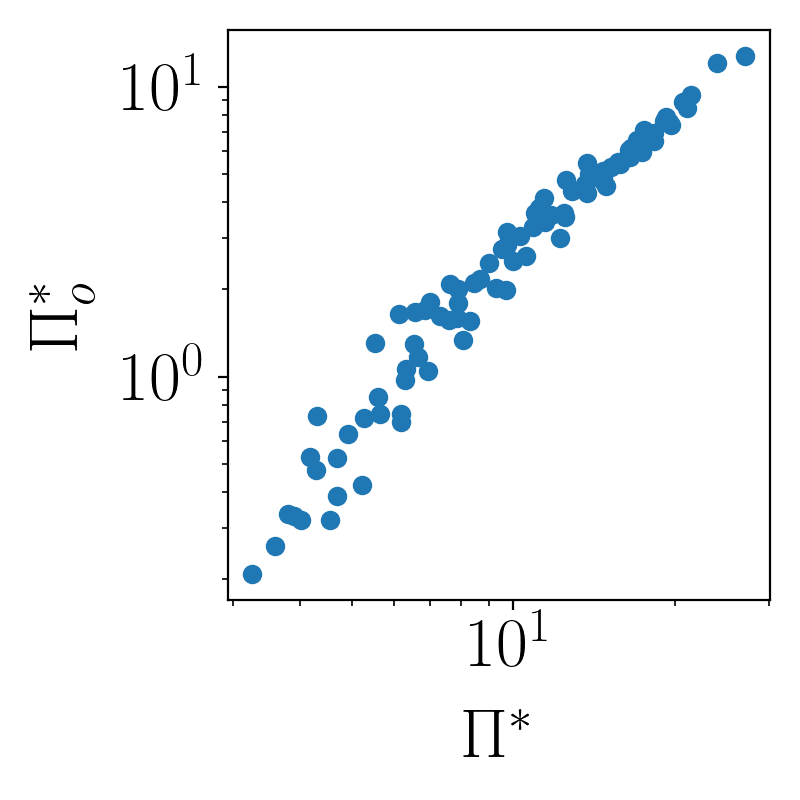

In [10]:
input_list = [calc_pi_omega(np.array(omega), X) for omega in normalized_coef_pi_list]
input_PI = np.column_stack(input_list)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Only needed for 3D
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering
if num_input == 1:
    fig = plt.figure(figsize=(4, 4))
    plt.scatter(input_PI[:, 0], Y)
    plt.xlabel(r"$\Pi^*$", fontsize=25, labelpad=10)
    plt.ylabel(r"$\Pi_o^*$", fontsize=25, labelpad=10)
    plt.xscale("log")
    plt.yscale("log")
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.tight_layout()
    fig.savefig("keyhole.eps", format="eps", bbox_inches="tight",transparent = "True")
    plt.show()

else:
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(input_PI[:, 0], input_PI[:, 1], Y)
    ax.set_xlabel(r"$\Pi^*_1$", fontsize=15, labelpad=10)
    ax.set_ylabel(r"$\Pi^*_2$", fontsize=15, labelpad=10)
    ax.set_zlabel(r"$\Pi_o^*$", fontsize=15, labelpad=10)
    plt.tight_layout()
    plt.show()


<IPython.core.display.Javascript object>


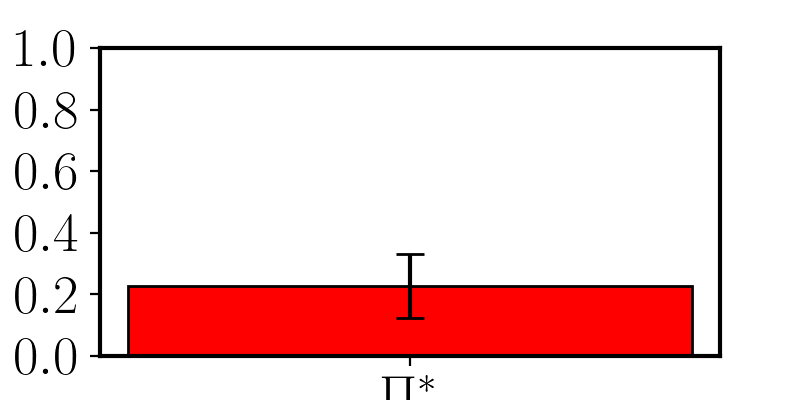

[0.2264547811418053]


In [11]:
# Function to calculate exp(-MI) bound and its uncertainty (UQ)
def calculate_bound_and_uq(input_data, output_data, num_trials):
    # Compute MI using all the data
    mi_full = KraskovMI1_nats(input_data, output_data, 5)
    exp_mi_full = np.exp(-mi_full)

    exp_mi_half_values = []
    for _ in range(num_trials):
        # Randomly select half of the data
        indices = np.random.choice(input_data.shape[0], size=input_data.shape[0] // 2, replace=False)
        input_half = input_data[indices]
        output_half = output_data[indices]
        # Compute MI for this subset and calculate exp(-MI_half)
        mi_half = KraskovMI1_nats(input_half, output_half, 5)
        exp_mi_half_values.append(np.exp(-mi_half))

    # Calculate the mean of exp(-MI_half)
    exp_mi_half_mean = np.mean(exp_mi_half_values)
    
    # UQ is the absolute difference between exp(-MI_full) and exp_mi_half_mean
    uq = abs(exp_mi_full - exp_mi_half_mean)
    
    return exp_mi_full, uq

Y = Y.reshape(-1,1)

# Initialize lists for results
exp_mi_values = []
uq_values = []
x_labels = []

# Number of trials for calculating exp(-MI_half)
num_trials = 10  # Adjust for accuracy vs computation time

# Check the number of columns in input_PI
if input_PI.shape[1] == 1:
    # Only one column, calculate and plot only the total MI
    exp_mi_full, uq = calculate_bound_and_uq((input_PI), (Y), num_trials)
    exp_mi_values.append(exp_mi_full)
    uq_values.append(uq)
    x_labels.append(r"$\mathbf{\Pi^*}$")
else:
    # Multiple columns, calculate exp(-I) for each column and the total MI
    for j in range(input_PI.shape[1]):
        exp_mi_full, uq = calculate_bound_and_uq(input_PI[:, j].reshape(-1, 1), Y, num_trials)
        exp_mi_values.append(exp_mi_full)
        uq_values.append(uq)
        x_labels.append(f"$\\Pi_{j+1}^*$")
    
    # Calculate exp(-I) for the entire input_PI and Y
    exp_mi_full, uq = calculate_bound_and_uq(input_PI, Y, num_trials)
    exp_mi_values.append(exp_mi_full)
    uq_values.append(uq)
    x_labels.append(r"$[\Pi_1^*,\Pi_2^*]$")

# Plotting the results
plt.figure(figsize=(4, 2))
x_labels[0] = r"$\Pi^{*}$"

plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)

# Use uq_values as the error bars
plt.bar(x_labels, exp_mi_values, yerr=uq_values, capsize=5, edgecolor='black',color = 'red')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel(r'$\tilde{\epsilon}_{L B}$', fontsize=25, labelpad=15)
plt.ylim([0, 1])
plt.savefig('Velocity_trans_rank.eps', dpi=300, bbox_inches='tight',transparent = 'True')
plt.show()
print(exp_mi_values)